In [1]:
version = "v2.0.042025.4"

# Assignment 4 - Tree-based classification & Synthesis Project

### Physiological Sensor Data Analysis (100 points)
This synthesis project is based on a dataset of physiological sensor measurements collected from Smartphone based sensors. The original research sought to determine the particular activity of the subject based on the physiological measurements obtained from wearables and a SmartPhone. The physiological measurements were used to depict the test subject in one of four activities as follows:  
   - neutral
   - emotional
   - mental
   - physical  
 
Your task will be to produce a model that, based on a limited number of features, returns the best possible estimate of the activity being performed by the test subject. While the original analysis utilized more advanced Machine Learning methods, we will concentrate on the supervised learning methods covered in this course.  

The sensor dataset consists of 4480 rows, each with the subject ID, the activity label and 533 measurement features! Each of the 40 test volunteers were subjected to a series of 28 data collection events for each of the four activity types presented above. As you explore this data, you will find that the features are arranged by a particular measurement mode, each consisting of similar statistical values.  
Before we get started, it will be necessary to ingest and prepare our data for training and testing purposes.  

**Notes**  
 - Any available random_state or seed values should be initialized with an integer value of 42.
 - Some standard package imports have been provided below.
 - Additional import deemed necessary for your analysis can be added in the cell following.

## library imports

In [2]:
# useful python standard libraries
import itertools
import math
import random

# import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# helpful SciKit-Learn libraries
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# We will use this variable name multiple times
base_feature_selector = "_mad_"

In [3]:
## suppress all warnings
## uncomment only if necessary!
# import warnings
# warnings.filterwarnings('ignore')

## Additional imports can be included here
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Question 1  (2 points)
### Import CSV Sensor Data file
 - The first order of business is to read the data file, '_sensor_data.csv_ ', from the '_assets/_ ' folder.
 - Your function should accept zero arguments and return a Pandas DataFrame.
 - Be aware that the activity labels are in a format that may or may not work with your chosen models. If you choose to reassign the activity labels, use the following:  
    - **'neutral' == 1**
    - **'emotional' == 2**
    - **'mental' == 3**
    - **'physical' == 4**

In [4]:
def get_sensor_data():
    df = pd.read_csv('assets/sensor_data.csv')

    return df

In [5]:
# use this cell to explore the data
# remember to comment the function call before submitting the notebook

get_sensor_data()

,Subject_ID,Activity_Label,ECG_original_mean_1,ECG_original_std_2,ECG_original_trimmean25_3,ECG_original_median_4,ECG_original_skewness_5,ECG_original_kurtosis_6,ECG_original_max_7,ECG_original_min_8,...,EDA_Functionals_power_Filt2skewness_524,EDA_Functionals_power_Filt2kurtosis_525,EDA_Functionals_power_Filt2max_526,EDA_Functionals_power_Filt2min_527,EDA_Functionals_power_Filt2prctile25_528,EDA_Functionals_power_Filt2prctile75_529,EDA_Functionals_power_Filt2geomean(abs)_530,EDA_Functionals_power_Filt2harmmean_531,EDA_Functionals_power_Filt2mad_532,EDA_Functionals_power_Filt2baseline_533
0,QNNG,neutral,-0.004125,0.254095,0.001426,-0.01037,-0.538509,5.95534,1.04063,-1.37437,...,31.4249,1015.36,7.170320e+08,0.027384,2.53425,17.3882,8.05589,1.80247,1413310.0,3028080.0
1,QNNG,neutral,0.031029,0.193761,0.012918,-0.00237,0.781415,5.18794,0.98963,-0.71937,...,31.4354,1015.78,7.058540e+08,0.016947,2.51513,16.5914,7.81769,1.52349,1390180.0,3016420.0
2,QNNG,neutral,0.015678,0.182336,-0.003028,-0.02337,0.881194,5.66530,0.87563,-0.71937,...,31.4480,1016.16,6.270180e+08,0.008129,2.25959,15.2312,7.11684,1.25860,1234110.0,3004430.0
3,QNNG,neutral,0.014525,0.176636,-0.006161,-0.02737,1.024900,6.10968,0.91063,-0.71937,...,31.4333,1015.61,5.597480e+08,0.007377,2.13924,14.4663,6.70236,1.26643,1102720.0,2992170.0
4,QNNG,neutral,0.010349,0.179248,-0.008526,-0.02737,0.935697,5.83902,0.91063,-0.75637,...,31.4346,1015.67,4.844730e+08,0.011448,1.93595,12.5493,6.08647,1.22387,954322.0,2979610.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4475,GMEC,physical,-0.015981,0.254373,-0.013341,-0.00101,-0.165105,5.15843,1.03999,-1.19301,...,31.4079,1014.61,3.237410e+09,0.132094,9.48535,73.9901,31.82590,5.16972,6390410.0,398810.0
4476,GMEC,physical,-0.008857,0.238946,-0.010767,-0.00901,-0.034522,5.43013,1.01499,-1.10201,...,31.4447,1016.07,3.156070e+09,0.133406,8.73701,68.4041,29.83820,5.06743,6214830.0,412407.0
4477,GMEC,physical,0.024672,0.213325,0.014417,0.01099,0.613841,4.55481,1.01499,-0.57301,...,31.4487,1016.06,3.052520e+09,0.138525,8.90410,68.5051,30.45150,5.88492,6011070.0,425422.0
4478,GMEC,physical,0.025063,0.212210,0.015656,0.01299,0.593249,4.58374,0.95799,-0.64101,...,31.4353,1015.80,3.322710e+09,0.076570,8.97766,72.4431,30.38700,4.43563,6544010.0,439695.0


In [6]:
# Autograder tests

stu_ans = get_sensor_data()

assert isinstance(
    stu_ans, pd.DataFrame
), "Q1: Your get_sensor_data function must return a Pandas DataFrame."

assert isinstance(
    stu_ans.iloc[0][2], np.float64
), "Q1: The dtype of the first row, third column, is incorrect."

del stu_ans

## Question 2  (3 points)
### Standard train_test_split
 - Our first exercise will be to produce a SciKit-Learn standard train/test split of a dataframe. In the following cell, complete the function that returns a standard train/test split of the sensor data.
   - The function should accept a dataframe as produced by get_sensor_data() and a test_split value which defaults to 0.2.
   - The function should return the standard X_train, X_test, y_train, y_test.

In [7]:
def std_train_test_split(df, test_split=0.2):

    X = df.iloc[:, 2:]
    y = df.iloc[:, 1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split, random_state = 42)

    return X_train, X_test, y_train, y_test

In [8]:
# Autograder tests

df = get_sensor_data()
stu_ans = std_train_test_split(df)

assert isinstance(stu_ans[0], pd.DataFrame), "Q2: X_train should be a pd.DataFrame"
assert isinstance(stu_ans[2], pd.Series), "Q2: y_train should be a pd.Series"

del stu_ans
del df

## Question 3  (5 Points)
### Build a baseline Tree model
- Complete the following function that will establish a baseline score.  
  - This function should retrieve and split the sensor data based on your previously constructed functions. Please use/default to, a split value of 0.2.  
  - Using a _for loop_ or [list comprehension](https://www.w3schools.com/python/python_lists_comprehension.asp), extract a list of feature names that includes the substring **base_feature_selector** defined in the **[library imports](#library-imports)** cell above.  
  - Create a [DecisionTreeClassifier](https://scikit-learn.org/0.24/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) with default hyperparameters and the predetermined random_state value.
    - Train this model on the features as extracted above.  
  - Using the classifier's [score method](https://scikit-learn.org/0.24/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.score), score the model using X_test and the previously extracted subset of features.  
  - Finally return a tuple consisting of the list of extracted features and score.  

In [9]:
def baseline_model_one():

    feature_selector = base_feature_selector
    
    df = get_sensor_data()
    X_train, X_test, y_train, y_test = std_train_test_split(df)

    limit_list = []
    for column in X_train.columns:
        if base_feature_selector in column:
            limit_list.append(column)
        
    X_train_limit = X_train[limit_list]
    X_test_limit = X_test[limit_list]
    
    tree = DecisionTreeClassifier(random_state = 42).fit(X_train_limit, y_train)
    score = tree.score(X_test_limit, y_test)
    features = list(X_train_limit.columns)

    return (features, score)

In [10]:
# use this cell to observe your results
# remember to comment the function call before submitting the notebook

#baseline_model_one()

In [11]:
# Autograder tests

stu_ans = baseline_model_one()

assert isinstance(stu_ans, tuple), "Q3: Your function should return a tuple."

assert isinstance(
    stu_ans[0], list
), "Q3: Tuple element zero should be a list object."

assert isinstance(
    stu_ans[1], np.float64
), "Q3: Tuple element one should be a np.float64 value."

del stu_ans

## Question 4  (3 Points)
### Baseline Tree model questions
1. Does the default accuracy score returned by the model seem reasonable to you; why or why not?
2. What might be the problem with this model or with the data?

Yes, this default accuracy score returned by the model was a big surprise as it was a very strong predictive score despite the default parameters for the Decision Tree Classifier being used, and depth, nodes, leaves, etc. not being allowed to be tuned. 

Most importantly, this is likely due to the standard train-test-split process and how it allows for an individual subject's readings to be included in both the training and the test datasets, which would be resulting in data leakage. This would have a significant impact on the model success (artificially inflate its predictive power) as the model, essentially, can train on both the training AND the testing data. This is leading to a model severely impacted by data leakage and it would perform poorly when new data was introduced outside of the training and testing sets.

## Question 5  (10 Points)
### A custom train_test_split function
 - Because of the nature of the original experiment's data collection methodology, the standard sklearn train_test_split() method cannot be applied successfully to this dataset. 
 - The first significant task will be to create a 'custom_train_test_split()' function that will correctly separate train data from test data, given the structure of the data in the sensor dataset.  
 - Your function should accept two arguments:  
   - A Pandas DataFrame such as returned by your get_sensor_data() function.
   - An integer ___or___ float value that indicates the number of or percentage of the test data split.  
   - Again, any random_state or seed values should be initialized with an integer value of 42.
 - Helpful Python Standard Libraries and functions:
   - [random](https://docs.python.org/3/library/random.html)  
     - random.seed()
     - random.choices()
   - [math](https://docs.python.org/3/library/math.html)  
     - math.floor()  
     - math.ceil()  
  
 - Questions to keep in mind while creating this function:
   - How might this function accept and use an integer or float value for the purpose of dividing the dataset?
   - How do I ensure consistent random selection for reproducibility?
   - Most importantly, how do I split this data to avoid one of the more devastating issues in machine learning?

In [12]:
def custom_train_test_split(df, test_split = 0.2):
    import math


    subjects = list(df['Subject_ID'].unique())
    random.seed(42)

    if test_split < 1:
        k = int(test_split * 40)
    else:
        k = test_split

    random_list = random.choices(subjects, k = k)
    test_subjects = df.loc[df['Subject_ID'].isin(random_list)]
    train_subjects = df.loc[~df['Subject_ID'].isin(random_list)]

    X_train = train_subjects
    X_test = test_subjects

    y_train = train_subjects.iloc[:, 1]
    y_test = test_subjects.iloc[:, 1]
    
    return X_train, X_test, y_train, y_test

In [13]:
# Autograder tests

test_split = 5
df = get_sensor_data()
stu_ans = custom_train_test_split(df, test_split)

assert isinstance(stu_ans[0], pd.DataFrame), "Q4: X_train should be a pd.DataFrame"
assert isinstance(stu_ans[2], pd.Series), "Q4: y_train should be a pd.Series"
assert len(stu_ans[1]) == 560, "Q4: The length of your X_test dataframe is incorrect"
assert len(stu_ans[3]) == 560, "Q4: The length of your y_test dataframe is incorrect"

del stu_ans

## Question 5, Part 2
### Run a baseline_model using your custom data splitter
- Copy/Paste your baseline model code from above into the function below.  
  - Replace the std_train_test_split() function with your new custom_train_test_split().
    - Use the default split of 0.2.
  - Run this revised function and answer the questions below.  

In [14]:
def baseline_model_two():
    feature_selector = base_feature_selector
    
    df = get_sensor_data()
    X_train, X_test, y_train, y_test = custom_train_test_split(df)
    
    X_train = X_train.iloc[:, 2:]
    X_test = X_test.iloc[:, 2:]

    limit_list = []
    for column in X_train.columns:
        if base_feature_selector in column:
            limit_list.append(column)
        
    X_train_limit = X_train[limit_list]
    X_test_limit = X_test[limit_list]
    
    tree = DecisionTreeClassifier(random_state = 42).fit(X_train_limit, y_train)
    score = tree.score(X_test_limit, y_test)
    features = list(X_train_limit.columns)

    return (features, score)

In [15]:
# examine your new baseline_model() here
# remember to comment the function call before submitting the notebook

#baseline_model_two()

In [16]:
# Autograder tests

stu_ans = baseline_model_two()

assert isinstance(stu_ans, tuple), "Q5: Your function should return a tuple."

assert isinstance(
    stu_ans[0], list
), "Q5: Tuple element zero should be a list object."

assert isinstance(
    stu_ans[1], np.float64
), "Q5: Tuple element one should be a np.float64 value."

del stu_ans

## Question 6  (2 Points)
### Custom train/test split questions
Is the score of the model that incorporates custom_train_test_split() significantly different from the std_train_test_split() version? What issue(s) have we eliminated with our new custom_train_test_split() function?

Yes, the score is significantly different (lower) from the standard split version. The data leakage issues has been eliminated with the custom split version as now individual subjects are grouped into the test or training data sets instead of their specific individual readings, which leads to the predictive performance expected of a default, non-tuned model (relatively poor).

## Question 7  (5 Points)
### Confusion Matrix
 - We now want to better understand the relationship of correct and incorrect predictons made by a classification model. A very useful tool for examining a multiclass outcome, such as we have with our sensor dataset, is the [Confusion Matrix](https://scikit-learn.org/0.24/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
 - Using the SciKit-Learn [LogisticRegression](https://scikit-learn.org/0.24/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) model, create a function that returns a Confusion Matrix.
   - Your function should accept zero arguments.  
   - Set hyperparameter: max_iter=1000
   - Any random_state or seed values should be initialized with an integer value of 42.
 - Use your previously defined functions to derive your train and test sets.
 - Scaling is an important factor in many Machine Learning projects (See section 3.3 in the course textbook). For the current dataset, use the sklearn method StandardScaler() to scale the train and test sets.
 - Using code that you had previously developed, include all features who's name includes the substring defined in 
**base_feature_selector** ([library imports](#library-imports)).
- Your function should return the following tuple:  
   - The confusion matrix array as returned by the sklean method confusion_matrix().  

In [17]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import confusion_matrix

def LR_confusion_matrix():

    df = get_sensor_data()
    X_train, X_test, y_train, y_test = custom_train_test_split(df)
    
    X_train = X_train.iloc[:, 2:]
    X_test = X_test.iloc[:, 2:]

    limit_list = []
    for column in X_train.columns:
        if base_feature_selector in column:
            limit_list.append(column)
        
    X_train_limit = X_train[limit_list]
    X_test_limit = X_test[limit_list]

    scaler = StandardScaler().fit(X_train_limit)
    X_train_limit = scaler.transform(X_train_limit)
    X_test_limit = scaler.transform(X_test_limit)

    log_model = LR(max_iter = 1000, random_state = 42).fit(X_train_limit, y_train)
    y_predict = log_model.predict(X_test_limit)

    conf_mtrx = confusion_matrix(y_test, y_predict)
    return conf_mtrx

In [18]:
# Autograder tests

stu_ans = LR_confusion_matrix()

assert isinstance(
    stu_ans, np.ndarray
), "Q7: The second tuple element should be an np.ndarray"

del stu_ans

### Visualizing the Confusion Matrix

In [19]:
def plot_confusion():
    cm = LR_confusion_matrix()
    labels = {"neutral": 1, "emotional": 2, "mental": 3, "physical": 4}.keys()
    display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    display_cm.plot()
    plt.show()

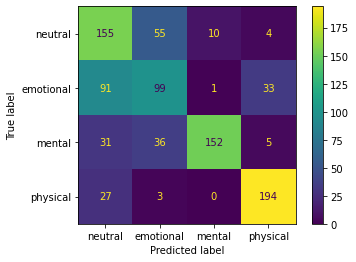

In [20]:
# view your confusion matrix here
# remember to comment the function call before submitting the notebook

plot_confusion()

## Question 8  (5 Points)
### Basic Confusion Matrix Understanding
 - Answer the following questions concerning the above Confusion Matrix.  
 - Record (hardcode) your answers in the answer variables in the cell below for autograding purposes.  
 
Q1. What is the number of __Correctly Predicted__ for the _mental_ activity?  
Q2. How many __False Positive__ predictions were made for the _neutral_ activity?  
Q3. How many __False Negative__ predictions were made for the _physical_ activity?  
Q4. What is the __Precision__ Score for the _mental_ activity? (round to three decimal places)  
Q5. What is the __Recall__ Score for the _emotional_ activity? (round to three decimal places)  
Q6. What is the overall __Accuracy__ for the current model? (round to three decimal places)  
Q7. Which activity is most confused for _mental_ activity when not?

In [21]:
# Supply your answers to Q1 through Q7
# in variables a1 through a7.

a1 = 152
a2 = 27+31+91
a3 = 27+3
a4 = round(152/(152+1+10), 3)
a5 = round(99/(99+91+1+33), 3)
a6 = round((155+99+152+194)/(155+99+152+194+91+31+27+55+36+3+10+1+4+33+5), 3)
a7 = 'emotional'


stu_ans = (a1, a2, a3, a4, a5, a6, a7)

In [22]:
# Autograder tests

assert (
    len(stu_ans) == 7
), "Q8: Your answer tuple does not contain the correct number of answers."
assert isinstance(stu_ans[0], int), "Q8: Answer one should be an integer"
assert isinstance(stu_ans[1], int), "Q8: Answer two should be an integer"
assert isinstance(stu_ans[2], int), "Q8: Answer three should be an integer"
assert isinstance(stu_ans[3], float), "Q8: Answer four should be a float"
assert isinstance(stu_ans[4], float), "Q8: Answer five should be a float"
assert isinstance(stu_ans[5], float), "Q8: Answer six should be a float"
assert isinstance(stu_ans[6], str), "Q8: Answer seven should be a string"

del stu_ans

## Question 9  (5 Points)
### Feature Importance part 1
#### Now we want to explore how some models are able to provide additional insight into the features that played a prominent role in the estimation outcome. 
 - Produce a function that implements a RandomForestClassifier model, which includes the [**feature_importances_**](https://scikit-learn.org/0.24/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_) attribute.
- The function accepts a single argument for the top X number of features, the default value will be 10.
  - The classifier should use only two parameters:
    - random_state=42
    - n_jobs=-1
- Use your previously defined functions to derive your train and test sets.
- Using code that you had previously developed, include all features who's name includes the substring defined by **base_feature_selector** ([library imports](#library-imports)).
 - The function should return a tuple of two elements.
   - The first element will be a **sorted** list of tuples in the form **\[('feature_name', importance_value),...\]**. The list of tuples should be sorted in descending order.
     - This list of tuples should be sorted in **descending order** of feature_importance.
   - The second element (test data score) should be an np.float64 value.

In [23]:
def get_top_features(top=10):
    
    df = get_sensor_data()
    X_train, X_test, y_train, y_test = custom_train_test_split(df)
    
    X_train = X_train.iloc[:, 2:]
    X_test = X_test.iloc[:, 2:]

    limit_list = []
    for column in X_train.columns:
        if base_feature_selector in column:
            limit_list.append(column)
        
    X_train_limit = X_train[limit_list]
    X_test_limit = X_test[limit_list]

    forest = RandomForestClassifier(n_jobs = 1, random_state = 42).fit(X_train_limit, y_train)
    importances = forest.feature_importances_

    zipped_importance = list(zip(X_train_limit.columns, importances))
    sorted_importance = sorted(zipped_importance, key=lambda x: x[1], reverse = True) 

    top_x = sorted_importance[:top]
    score = forest.score(X_test_limit, y_test)
    
    return top_x, score

In [24]:
# review your results here
# remember to comment the function call before submitting the notebook

#get_top_features()

In [25]:
# Autograder tests

stu_ans = get_top_features()

assert (
    len(stu_ans) == 2
), "Q9: Your answer tuple does not contain the correct number of elements."

assert isinstance(stu_ans[0], list), "Q9: The first tuple element should be a list"

assert len(stu_ans[0]) == 10, "Q9: The default number of top features is not correct."

assert isinstance(
    stu_ans[1], np.float64
), "Q9: get_top_features() second return element should be an np.float64."

del stu_ans


## Question 10  (10 Points)
### Feature Importance part 2
#### The value of Feature Importance 
- This follow-on question will use the same **RandomForestClassifier** model as in your get_top_features() function.
- The new model will use a portion of the output returned by the get_top_features() function.
- Use the previously defined functions to derive your train and test datasets.
- Create a loop that trains your model with an incrementally increasing number of features from the top features list.
  - The first pass will include the topmost important feature, the second pass will include the top two most important features and so on until the final pass of all top X features.
- Your function should return a list of feature-based test data scores produced by the model.

In [26]:
def score_top_features(top=10):

    scores = []
    df = get_sensor_data()
    X_train, X_test, y_train, y_test = custom_train_test_split(df)
    
    X_train = X_train.iloc[:, 2:]
    X_test = X_test.iloc[:, 2:]

    limit_list = []
    for column in X_train.columns:
        if base_feature_selector in column:
            limit_list.append(column)
        
    X_train_limit = X_train[limit_list]
    X_test_limit = X_test[limit_list]

    forest = RandomForestClassifier(n_jobs = 1, random_state = 42).fit(X_train_limit, y_train)
    importances = forest.feature_importances_

    zipped_importance = list(zip(X_train_limit.columns, importances))
    sorted_importance = sorted(zipped_importance, key=lambda x: x[1], reverse = True) 
    feature_list = [x[0] for x in sorted_importance[:top]]

    for i in range(top):
        features = feature_list[:i+1]
        X_train_loop = X_train_limit[features]
        X_test_loop = X_test_limit[features]
    
        forest = RandomForestClassifier(n_jobs = 1, random_state = 42).fit(X_train_loop, y_train)
        score = forest.score(X_test_loop, y_test)
        scores.append(score)

    return scores

In [27]:
# review your top features results here
# remember to comment the function call before submitting the notebook

#score_top_features()

In [28]:
# Autograder tests

top = 10
stu_ans = score_top_features(top)

assert (
    len(stu_ans) == top
), "Q10: Your function does not return the correct number of scores."

assert all(
    isinstance(x, np.float64) for x in stu_ans
), "Q10: One or more of the returned scores is of an incorrect type."

del stu_ans

In [29]:
def plot_scores(top=10):

    if top > 29:
        top = 29

    top_x_features, score = get_top_features(top)
    scores = score_top_features(top)

    importance_scores = [score[1] for score in top_x_features]
    x_axis = np.arange(1, len(scores) + 1)

    plt.figure(figsize=(8, 6))

    plt.plot(x_axis, scores, label="Accuracy Score", c="g", linestyle="solid")
    plt.plot(
        x_axis,
        importance_scores,
        label="Feature Importance Scores",
        c="r",
        linestyle="solid",
    )
    plt.axhline(
        score,
        label=f"All '{base_feature_selector}' features score",
        c="b",
        linestyle="dashed",
    )

    plt.xticks(x_axis)
    plt.ylim([0, max(score, max(importance_scores)) + 0.05])
    plt.xlabel("Number of Top 10 Features Used")
    plt.ylabel("Score Value")
    plt.grid(alpha=0.25)
    plt.legend()
    plt.show()

    return

## Scores Plot
The plot_scores() function accepts top X features argumnet which defaults to a value of 10. Feel free to change the argument to better see how accuracy is affected by the number of top features used to train the model.

In [30]:
# Plot accuracy vs feature importance
# the plot_scores() function will accept a
# remember to comment the function call before submitting the notebook

#plot_scores()

## Question 11  (50 Points)
### Final project
- The final question for this assignment is open-ended with only a few **constraints**. Using any of the Supervised Machine Learning techniques and models presented in this course, produce a model that produces a best-possible ROC-AUC score. Your Question 11 award points will be evaluated solely on this score. The primary constraint for this question is that you will be able to utilize not more than **10** of the 533 available data features in the training and scoring of your model. A quick calculation of the number of available combinations C(n, r) = C(533, 10) = $\frac{n!}{r!(n-r)!}$ = 4.684e20. That is very large number of possible combinations (the number of permutations is even greater)! Because of the intractability of checking all possible 10-feature combinations, it will be necessary to devise a scheme whereby your algorithm makes a selection of features and scores that selection. Be creative but also efficient in your feature selection process. Because multiple feature selection cycles may be necessary, you will also need to develop an efficient method of keeping track of the top model, features, and score.  

- Why would we want to limit the number of features? 
   1. The creator of the project may want to minimize the number of sensors/measurements required to move the project forward.
   2. The final product will be used on a smartphone where resource consumption is always a concern.
   3. Computational resource availability of the development environment could be constrained due to budget availability.
   4. The development environment may be intentionally constrained to mimic the production environment.
  
- You will find that even with these limitations, some model choices will still consume significant resources, even to the point of crashing the Python kernel!  

- The activity_model() function:
  - Arguments: none
  - Use your previously defined functions to derive your train and test sets.
  - If feasible, expand upon your previously created feature selection code.
  - Use the following parameters when establishing your [roc_auc_score](https://scikit-learn.org/0.24/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) method:
    - average="macro"
    - multi_class="ovr"
  - return: a tuple consisting of (fit_model, feature_list, roc_auc_score)

In [31]:
df = get_sensor_data()
X_train, X_test, y_train, y_test = custom_train_test_split(df)
    
X_train = X_train.iloc[:, 2:]
X_test = X_test.iloc[:, 2:]

stop = 0
i = 0

while stop == 0:
    train_sample = X_train.sample(n=10, axis = 'columns', random_state = i)
    test_sample = X_test.sample(n=10, axis = 'columns', random_state = i)
    forest = RandomForestClassifier(max_features = 10, max_depth = 4, n_jobs = 1, random_state = 42).fit(train_sample, y_train)
    forest_prob = forest.predict_proba(test_sample)
    
    score = roc_auc_score(y_test, forest_prob, average = 'macro', multi_class = 'ovr')
    if score > .91:
        stop = 1
    i+=1


In [32]:
def activity_model():
    
    df = get_sensor_data()
    X_train, X_test, y_train, y_test = custom_train_test_split(df)
    
    X_train = X_train.iloc[:, 2:]
    X_test = X_test.iloc[:, 2:]

    stop = 0
    i = 0

    while stop == 0:
        train_sample = X_train.sample(n=10, axis = 'columns', random_state = i)
        test_sample = X_test.sample(n=10, axis = 'columns', random_state = i)
        forest = RandomForestClassifier(max_features = 10, max_depth = 4, n_jobs = 1, random_state = 42).fit(train_sample, y_train)
        forest_prob = forest.predict_proba(test_sample)
    
        score = roc_auc_score(y_test, forest_prob, average = 'macro', multi_class = 'ovr')
        if score > .91:
            stop = 1
        i+=1

    return (forest, list(test_sample.columns), score)

In [33]:
# review your activity_model() return here
# remember to comment the function call before submitting the notebook

#activity_model()

In [34]:
# Hidden autograder model validation
# test for AUC score >= 0.83

stu_ans = activity_model()

assert (
    stu_ans[2] >= 0.83
), f"Q11: Your test AUC {stu_ans[2]:.4f} is less than 0.83. You will not receive any points for this question."

In [35]:
# autograder test - AUC >= 0.85


assert (
    stu_ans[2] >= 0.85
), f"Q11: Your test AUC {stu_ans[2]:.4f} is less than 0.85. You will receive 25 points for this question."

In [36]:
# autograder test - AUC >= 0.87


assert (
    stu_ans[2] >= 0.87
), f"Q11: Your test AUC {stu_ans[2]:.4f} is less than 0.87. You will receive 30 points for this question."

In [37]:
# autograder test - AUC >= 0.89


assert (
    stu_ans[2] >= 0.89
), f"Q11: Your test AUC {stu_ans[2]:.4f} is less than 0.89. You will receive 35 points for this question."

In [38]:
# autograder test - AUC >= 0.91


assert (
    stu_ans[2] >= 0.91
), f"Q11: Your test AUC {stu_ans[2]:.4f} is less than 0.91. You will receive 45 points for this question."

del stu_ans